### G27
Dave Brunner

In [1]:
import math

import torch
from torch import nn
from torch.utils.data import DataLoader
from torchvision import datasets
from torchvision.transforms import ToTensor
from torchsummary import summary
import numpy as np
import matplotlib.pyplot as plt

In [2]:
torch.set_default_device('cpu')
if torch.cuda.is_available():
    print("cuda would be available, but not set")
    # torch.set_default_device('cuda')
else:
    print("cuda is not available")
if torch.backends.mps.is_available():
    print("mps would be available, but not set")
    mps_device = torch.device("mps")

cuda is not available


### Loading Data

In [3]:
training_data = datasets.mnist.FashionMNIST(root="data", train=True, download=True, transform=ToTensor())
test_data = datasets.mnist.FashionMNIST(root="data", train=False, download=True, transform=ToTensor())

In [4]:
training_data, validation_data = torch.utils.data.random_split(training_data, [50000, 10000])

In [5]:
print(len(training_data), len(validation_data), len(test_data))

50000 10000 10000


### Exercise 2: Fixed MLP with Increasing Training Dataset

Create a MLP with one hidden layer with 200 units for Fashion MNIST classification. Use ReLU activation.

Use a random fraction of the training set (split above) to perform the training. Always use the same validation set.

Use SGD and cross-entropy loss and suitable learning rate.

Start with a single small batch for training (batch size 8) and make sure that you can overfit, i.e. bring the training accuracy to 100%.

Then, gradually increase the training set. Let it grow until you obtain values for the training and the validation loss which no longer indicate overfitting. Use a fixed batch size (batchsize 32).

#### MLP Class

In [29]:
def mlp(units=[28 * 28, 200, 10]):
    class MLP(nn.Module):
        def __init__(self):
            super(MLP, self).__init__()
            self.initialize_layers()

        def initialize_layers(self):
            if len(units) == 3:
                self.sequential = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(units[0], units[1]),
                    nn.ReLU(),
                    nn.Linear(units[1], units[2])
                )
            elif len(units) == 4:
                self.sequential = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(units[0], units[1]),
                    nn.ReLU(),
                    nn.Linear(units[1], units[2]),
                    nn.ReLU(),
                    nn.Linear(units[2], units[3])
                )
            elif len(units) == 5:
                self.sequential = nn.Sequential(
                    nn.Flatten(),
                    nn.Linear(units[0], units[1]),
                    nn.ReLU(),
                    nn.Linear(units[1], units[2]),
                    nn.ReLU(),
                    nn.Linear(units[2], units[3]),
                    nn.ReLU(),
                    nn.Linear(units[3], units[4])
                )

        def forward(self, x):
            return self.sequential(x)

    return MLP()

In [34]:
# create an instance and its summary

model = mlp([28 * 28, 200, 300, 400, 10])
from torchsummary import summary

summary(model, (1, 28, 28))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
           Flatten-1                  [-1, 784]               0
            Linear-2                  [-1, 200]         157,000
              ReLU-3                  [-1, 200]               0
            Linear-4                  [-1, 300]          60,300
              ReLU-5                  [-1, 300]               0
            Linear-6                  [-1, 400]         120,400
              ReLU-7                  [-1, 400]               0
            Linear-8                   [-1, 10]           4,010
Total params: 341,710
Trainable params: 341,710
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.02
Params size (MB): 1.30
Estimated Total Size (MB): 1.33
----------------------------------------------------------------


#### Training Loop 

In [28]:
def train_eval(model, lr, nepochs, nbatch, training_data, validation_data, verbose=True):
    cost_hist = []
    cost_hist_validation = []
    acc_hist = []
    acc_hist_validation = []

    cost_fn = torch.nn.CrossEntropyLoss()
    train_loader = DataLoader(training_data, batch_size=nbatch, shuffle=True)
    val_loader = DataLoader(validation_data, batch_size=len(validation_data), shuffle=True)
    optimizer = torch.optim.SGD(model.parameters(), lr=lr)

    if verbose:
        print(f"Batch size: {nbatch}")
        print(f"Size of train set: {len(training_data)}")
        print(f"Size of validation set: {len(validation_data)}")
        print("Start training.... ->")
        print("--------------------------------------")

    for epoch in range(nepochs):
        acc_train = 0
        loss_train = 0
        total = 0
        for batch_idx, (train_x, train_y) in enumerate(train_loader):
            pred_train = model(train_x)
            loss = cost_fn(pred_train, train_y)

            # calculate performance scores
            acc_train += (pred_train.argmax(1).eq(train_y)).type(torch.float).sum().item()
            total += len(train_y)
            loss_train += loss.item()

            # update parameters
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

        cost_hist.append(loss_train / len(train_x))
        acc_hist.append(acc_train / total)

        with torch.no_grad():
            for (val_x, val_y) in val_loader:
                pred_val = model(val_x)
                loss_val = cost_fn(pred_val, val_y)
                cost_hist_validation.append(loss_val.item())
                acc_val = (pred_val.argmax(1).eq(val_y)).type(torch.float).sum().item() / (len(val_y))
                acc_hist_validation.append(acc_val)
        if verbose:
            print(f"Epoch: {epoch + 1}")
            print(f"Train:      Accuracy={acc_hist[-1]:.4f}, Cost: {cost_hist[-1]:.4f}")
            print(f"Validation: Accuracy={acc_hist_validation[-1]:.4f}, Cost: {cost_hist_validation[-1]:.4f}")
            print("--------------------------------------")
    if not verbose:
        print(f"Final Validation Accuracy={acc_hist_validation[-1]:.4f} Cost: {cost_hist_validation[-1]:.4f}")
        print(f"Final Training   Accuracy={acc_hist[-1]:.4f} Cost: {cost_hist[-1]:.4f}")
    return cost_hist, cost_hist_validation, acc_hist, acc_hist_validation

In [25]:
def train_plot_scores(fun, params_list: list):
    cost_train, cost_valid, acc_train, acc_valid = fun(*params_list)
    plt.figure(1)
    plt.plot(range(nepochs), acc_train, "b-", label="Training acc")
    plt.plot(range(nepochs), acc_valid, "r-", label="Validating acc")
    plt.title("Training and validation accuracy")
    plt.xlabel("Epochs")
    plt.ylabel("Accuracy")
    plt.legend()

    plt.figure(2)
    plt.plot(range(nepochs), cost_train, "b-", label="Training cost")
    plt.plot(range(nepochs), cost_valid, "r-", label="Validating cost")
    plt.title("Training and validation cost")
    plt.xlabel("Epochs")
    plt.ylabel("Cost")
    plt.legend()


#### First Training

Run a first training with only one small training batch (e.g. with a single batch of 64 samples). 
The small training set can be created by using the functionality `torch.utils.data.random_split` already used above. As validation set use the `validation_data` created above.  

This training run can be used to test whether the model and training loop are properly implemented. Explain why and in what sense it can be used as test.

This is something you can always do when training a model.

Batch size: 32
Size of train set: 32
Size of validation set: 10000
Start training.... ->
--------------------------------------
Epoch: 1
Train:      Accuracy=0.1250, Cost: 0.0720
Validation: Accuracy=0.1772, Cost: 2.2743
--------------------------------------
Epoch: 2
Train:      Accuracy=0.3438, Cost: 0.0685
Validation: Accuracy=0.1912, Cost: 2.2436
--------------------------------------
Epoch: 3
Train:      Accuracy=0.3750, Cost: 0.0657
Validation: Accuracy=0.2000, Cost: 2.2196
--------------------------------------
Epoch: 4
Train:      Accuracy=0.4062, Cost: 0.0631
Validation: Accuracy=0.2106, Cost: 2.1991
--------------------------------------
Epoch: 5
Train:      Accuracy=0.4375, Cost: 0.0607
Validation: Accuracy=0.2210, Cost: 2.1790
--------------------------------------
Epoch: 6
Train:      Accuracy=0.4688, Cost: 0.0584
Validation: Accuracy=0.2326, Cost: 2.1567
--------------------------------------
Epoch: 7
Train:      Accuracy=0.5625, Cost: 0.0562
Validation: Accuracy=0.2559, 

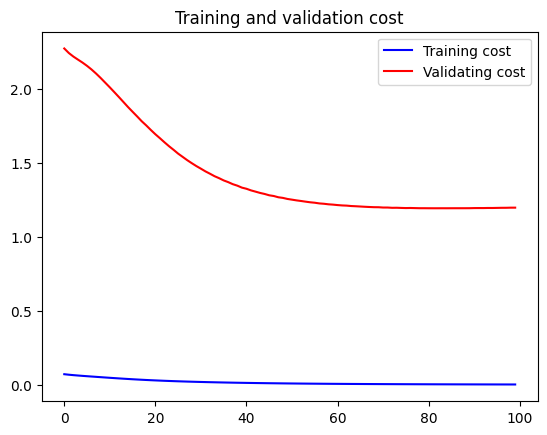

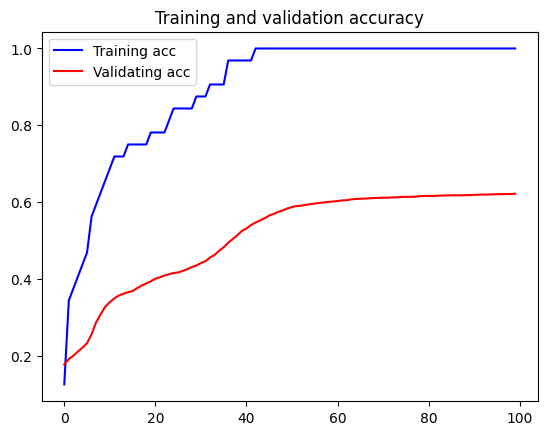

In [26]:
nbatch = 32
nbatches = 1
nepochs = 100
lr = 0.1

trainsize = nbatches * nbatch
trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000 - trainsize])

model = mlp([28 * 28, 200, 10])
train_plot_scores(train_eval, [model, lr, nepochs, nbatch, trainset, validation_data])

#### Evaluate Train and Validation Performance 

Now run several trainings with the same small model (one hidden layer) and explore for different number of training samples (different number of batches with 32 samples) used, how the train and validation performance evolve (cost and accuracy). Make sure that you train sufficiently long to obtain representative values for cost and accuracy with the given settings. Always use the same validation set (with 10'000 samples).

Create plots with training and validation performance vs number of training batches (one for cost and one for accuracy). Use the performance characteristics obtained at the end.

Discuss the whether there is a sufficient number of training samples for the given problem at hand. Specify a minimum number if applicable. Also consider whether you are in the underfitting regime.

Hint: Specify a list with the number of training batches you would like to perform trainings. Try to be economic with the resources used - try to keep the number of trainings limited.

Final Validation Accuracy=0.6460 Cost: 0.9860
Final Training   Accuracy=0.5594 Cost: 1.1267
Final Validation Accuracy=0.7027 Cost: 0.8230
Final Training   Accuracy=0.6797 Cost: 0.6740
Final Validation Accuracy=0.7464 Cost: 0.7196
Final Training   Accuracy=0.7381 Cost: 0.5729
Final Validation Accuracy=0.7460 Cost: 0.6906
Final Training   Accuracy=0.7625 Cost: 0.5293
Final Validation Accuracy=0.7969 Cost: 0.6106
Final Training   Accuracy=0.7844 Cost: 0.4819
Final Validation Accuracy=0.7904 Cost: 0.5951
Final Training   Accuracy=0.8037 Cost: 0.4454
Final Validation Accuracy=0.7637 Cost: 0.6472
Final Training   Accuracy=0.8175 Cost: 0.4159
Final Validation Accuracy=0.7958 Cost: 0.5909
Final Training   Accuracy=0.8191 Cost: 0.4105
Final Validation Accuracy=0.7967 Cost: 0.5897
Final Training   Accuracy=0.8281 Cost: 0.3871
Final Validation Accuracy=0.7962 Cost: 0.5919
Final Training   Accuracy=0.8287 Cost: 0.3908
Final Validation Accuracy=0.8068 Cost: 0.5438
Final Training   Accuracy=0.8422 C

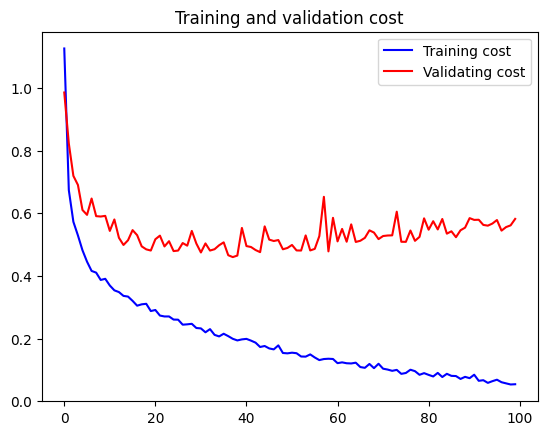

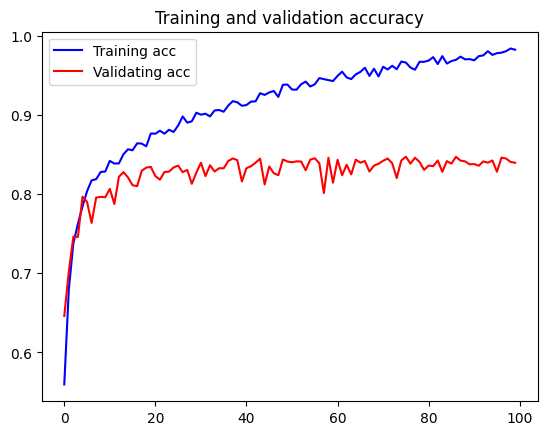

In [27]:
nbatch = 32
nbatches = 50
nepochs = 250
lr = 0.1

trainsize = nbatches * nbatch
trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000 - trainsize])

model = mlp([28 * 28, 200, 10])
print(f"Training set size: {len(trainset)}")
train_plot_scores(train_eval, [model, lr, nepochs, nbatch, trainset, validation_data, False])

In [ ]:
nbatch = 32
nbatches = 100
nepochs = 200
lr = 0.1

trainsize = nbatches * nbatch
trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000 - trainsize])

model = mlp([28 * 28, 200, 10])
print(f"Training set size: {len(trainset)}")
train_plot_scores(train_eval, [model, lr, nepochs, nbatch, trainset, validation_data, False])

#### Comments: YOUR comments

### Exercise 3: Evaluate Different Model Complexities

Use the same functionality implemented above (create MLP model, train and evaluate model) to evaluate different model complexities: Number of layers and number of units per layer.

Start with the small model used in Exercise 2. Then gradually increase the model complexity. Do this along two dimensions:
* a single hidden layer, but increasing the number of units.
* a fixed number of units per (hidden) layer, but increase the number of layers.
Make sure that you reach the overfitting regime (in either case).

Always use the full training set with 50'000 samples.

Again make sure that you train sufficiently long so that the obtained train and validation performance measures (cost, accuracy) are representative.

Create plots with training and validation performance (cost, accuracy) vs model complexity - one plot with number of units for the single hidden layer case, and one for varying number of layers. 

Again use the performance characteristics obtained at the end. 

Finally, discuss your findings.

Single hidden layer size: 300
Final Validation Accuracy=0.8366 Cost: 0.8323
Final Training   Accuracy=1.0000 Cost: 0.0076
---------------------------------
Single hidden layer size: 350
Final Validation Accuracy=0.8387 Cost: 0.8196
Final Training   Accuracy=1.0000 Cost: 0.0079
---------------------------------
Single hidden layer size: 400
Final Validation Accuracy=0.8390 Cost: 0.8326
Final Training   Accuracy=1.0000 Cost: 0.0077


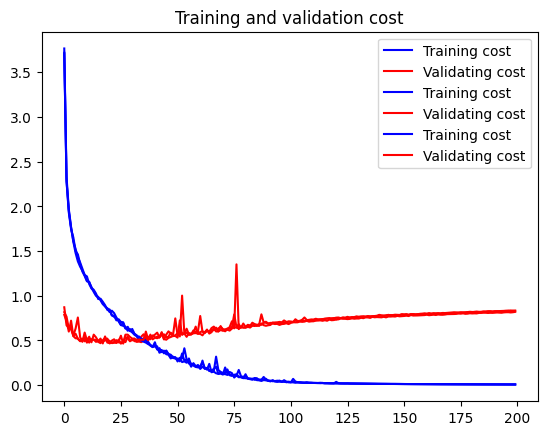

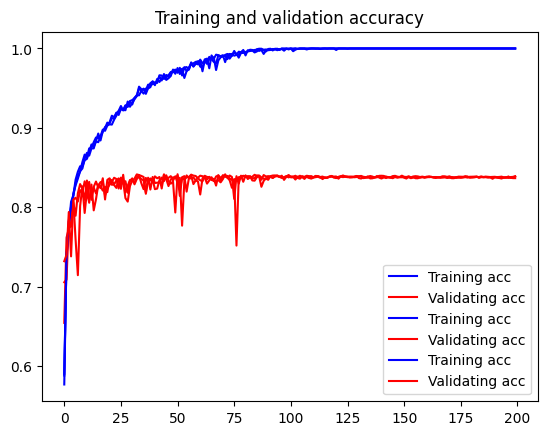

In [35]:
nbatch = 32
nbatches = 100
nepochs = 200
lr = 0.1

trainsize = nbatches * nbatch
trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000 - trainsize])

model = mlp([28 * 28, 300, 10])
print(f"Single hidden layer size: 300")
train_plot_scores(train_eval, [model, lr, nepochs, nbatch, trainset, validation_data, False])
print("---------------------------------")
model = mlp([28 * 28, 350, 10])
print(f"Single hidden layer size: 350")
train_plot_scores(train_eval, [model, lr, nepochs, nbatch, trainset, validation_data, False])
print("---------------------------------")
model = mlp([28 * 28, 400, 10])
print(f"Single hidden layer size: 400")
train_plot_scores(train_eval, [model, lr, nepochs, nbatch, trainset, validation_data, False])

Single hidden layer size: 300
Final Validation Accuracy=0.8428 Cost: 0.8209
Final Training   Accuracy=1.0000 Cost: 0.0081
---------------------------------
Single hidden layer size: 350
Final Validation Accuracy=0.8455 Cost: 0.8144
Final Training   Accuracy=1.0000 Cost: 0.0080
---------------------------------
Single hidden layer size: 400
Final Validation Accuracy=0.8412 Cost: 0.8027
Final Training   Accuracy=1.0000 Cost: 0.0078


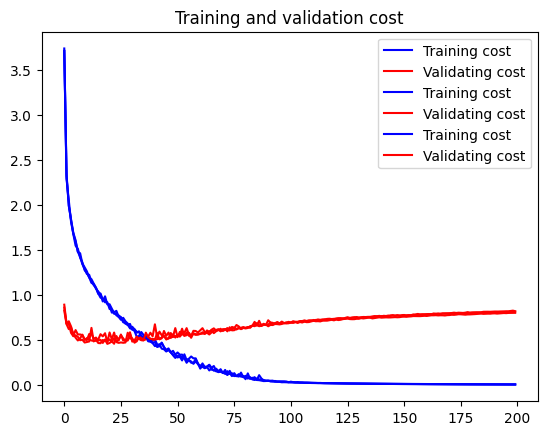

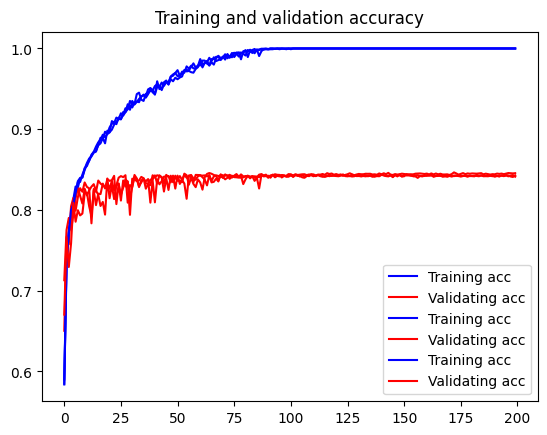

In [36]:
nbatch = 32
nbatches = 100
nepochs = 200
lr = 0.1

trainsize = nbatches * nbatch
trainset, rest = torch.utils.data.random_split(training_data, [trainsize, 50000 - trainsize])

In [ ]:
model = mlp([28 * 28, 300, 10])
print(f"Single hidden layer size: 300")
train_plot_scores(train_eval, [model, lr, nepochs, nbatch, trainset, validation_data, False])

In [ ]:
model = mlp([28 * 28, 350, 10])
print(f"Single hidden layer size: 350")
train_plot_scores(train_eval, [model, lr, nepochs, nbatch, trainset, validation_data, False])
print("---------------------------------")

In [ ]:
model = mlp([28 * 28, 400, 10])
print(f"Single hidden layer size: 400")
train_plot_scores(train_eval, [model, lr, nepochs, nbatch, trainset, validation_data, False])

#### Comments: YOUR findings.

### Exercise 4: Add Regularisation

Finally, add regularisation - dropout or L1/L2-regularisation. 

To this end, you need to implement new functionality to instantiate the model.

Start with one of the overfitting cases of Exercise 3 and try to improve the validation performance by adding regularisation. You can use either dropout or L1/L2-regularisation.


In [ ]:
# define a method that provides an instance of an MLP incl regularisation which uses as a list of units per layer as input 

def mlp_dropout(units=[28 * 28, 200, 10], p_in=0.2, p_hidden=0.5):
    """
    Creates an instance of an MLP with layers as specified in the 'units'-list (list of integers) and dropout 
    regularisation. Dropout rate for all layers the same except for the first (p_in). For the output layer 
    no dropout applied. 
    """

    # YOUR CODE HERE #



In [ ]:
model = mlp_dropout([28 * 28, 200, 10])

from torchsummary import summary

summary(model, (1, 28, 28))

#### Playing with different complexities and regularisation

Now play with different complexities and regularisation. 
Start with one of the overfitting cases identified in the previous exercise.
By adding regularisation, you should be able to make it non-overfitting, i.e. generalising better.
Note that for a given complexity, adding regularisation reduces the model capacity. This may need to be compensated by increasing the complexity of the model. 

Use again cost and accuracy for train and validation set to evaluate the results.

Finally, estimate the bias error and the generalisation error. 

In [ ]:

# YOUR CODE HERE #

